# Pattern Recognition Homework 4
* **Date** 12/11/2016
* **Author** [Haonan Chen](https://chaonan99.github.io/)
* **Student No.** 2013011449
* **Class** 32

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import KMeans

# PCA decomposition
This chapter use PCA in scikit-learn to get variances of different principle components and choose the number of components to be fed into cluster algorithm.

In [2]:
# Read data and conduct prepocessing
train_df = pd.read_table("../../h3/src/dataset3.txt", header=None)
test_df = pd.read_table("../../h3/src/dataset4.txt", header=None)
le = LabelEncoder()
le.fit(['M','F'])
y_train = le.transform(np.char.upper(train_df.loc[:, 10].values.astype(str)))
y_test = le.transform(np.char.upper(test_df.loc[:, 10].values.astype(str)))

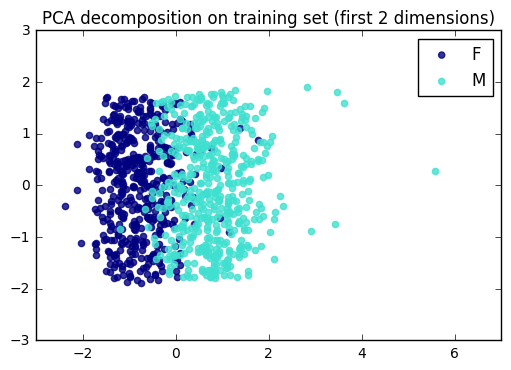

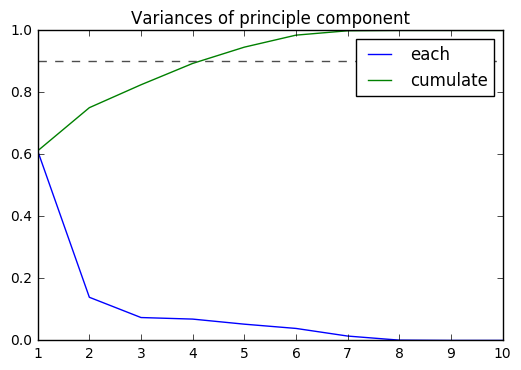

In [3]:
pca = PCA(n_components=10, whiten=True)  # Fit the model with all features
X_r = pca.fit(train_df.loc[:, 0:9]).transform(train_df.loc[:, 0:9])
plt.figure()
colors = ['navy', 'turquoise']
for color, i, target_name in zip(colors, [0, 1], ["F","M"]):
    plt.scatter(X_r[y_train == i, 0], X_r[y_train == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA decomposition on training set (first 2 dimensions)')
plt.show()
X_coord = np.arange(1,11)
plt.plot(X_coord, pca.explained_variance_ratio_, label='each')
plt.plot(X_coord, np.cumsum(pca.explained_variance_ratio_), label='cumulate')
plt.plot(X_coord, [0.9]*10, ls="--", c=".3")
plt.title("Variances of principle component")
plt.legend()
plt.show()

To reserve 90% variance, choose the first 4 principle components.

# K-means cluster
This chapter use k-means algorithm to cluster data decomposed to 4 dimensions by PCA. We compare different number of groups

In [4]:
def bench_cluster(estimator, data, labels):
    t0 = time()
    estimator.fit(data)
    return ["{:.2f}s".format(time() - t0), "{:.2f}".format(estimator.inertia_),
            "{:.3f}".format(metrics.silhouette_score(data, estimator.labels_,
            metric='euclidean'))]

pca = PCA(n_components=4, whiten=True)
X_r = pca.fit(train_df.loc[:, 0:9]).transform(train_df.loc[:, 0:9])
res = pd.DataFrame([bench_cluster(KMeans(init='k-means++', n_clusters=i, n_init=10), X_r, y_train)
              for i in range(2,10)], columns=["time", "inertia", "silhouette"],
             index=["class={}".format(i) for i in range(2,10)])
res

,time,inertia,silhouette
class=2,0.07s,3104.65,0.195
class=3,0.10s,2640.47,0.204
class=4,0.11s,2290.61,0.199
class=5,0.10s,1985.37,0.206
class=6,0.12s,1790.49,0.196
class=7,0.14s,1640.49,0.201
class=8,0.13s,1528.77,0.206
class=9,0.13s,1433.26,0.203


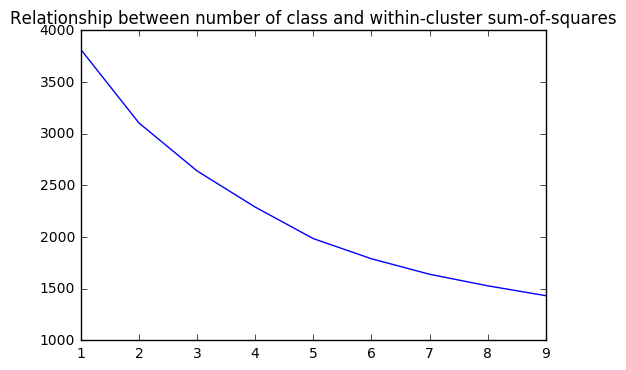

In [5]:
sum_square = [(X_r**2).sum()]
sum_square.extend(res['inertia'].values.astype(float))
plt.plot(range(1,10), sum_square)
plt.title("Relationship between number of class and within-cluster sum-of-squares")
# plt.subplots_adjust(left=-0.5, right=0.5, top=0.6, bottom=-0.6)
plt.show()

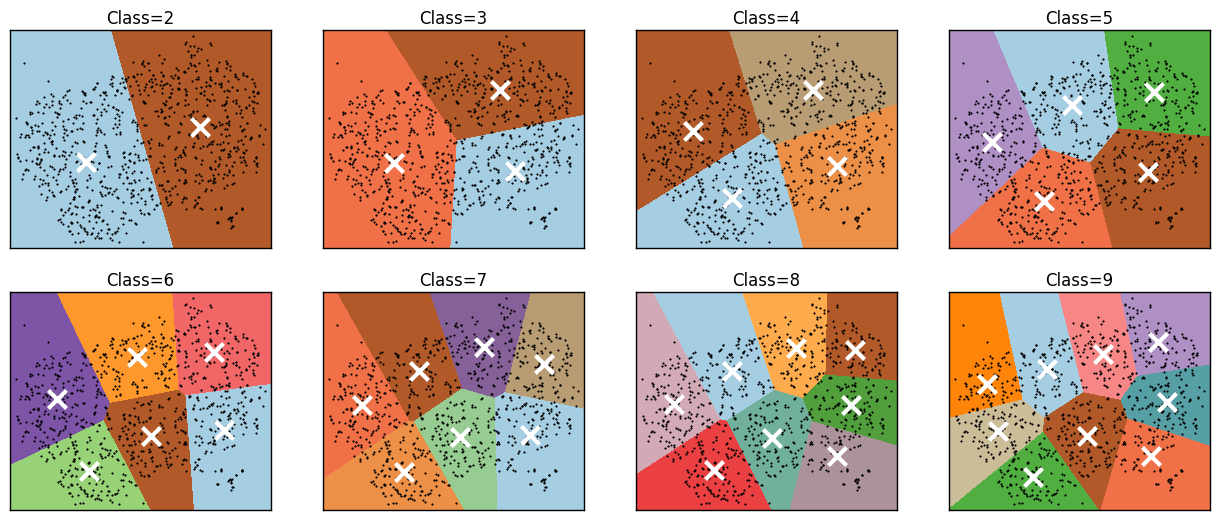

In [6]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
reduced_data = model.fit_transform(train_df.loc[:, 0:9])
plt.figure(1)
plt.clf()
f, axes = plt.subplots(2, 4)
for n_clusters in range(2,10):
    ax = (n_clusters - 2) / 4
    ay = (n_clusters - 2) % 4
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
    kmeans.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    axes[ax][ay].imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    axes[ax][ay].plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    axes[ax][ay].scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    axes[ax][ay].set_title('Class={}'.format(n_clusters))
    axes[ax][ay].set_xlim(x_min, x_max)
    axes[ax][ay].set_ylim(y_min, y_max)
    axes[ax][ay].set_xticks(())
    axes[ax][ay].set_yticks(())
f.subplots_adjust(left=-1, right=1, top=0.6, bottom=-0.6)
plt.show()

# Hierarchical Cluster
This chapter evaluates the clustering performance of different metrics and number of groups for hierarchical cluster method.

In [7]:
from sklearn.cluster import AgglomerativeClustering
def bench_hierarchical(estimator, data, labels):
    estimator.fit(data)
    return metrics.silhouette_score(data, estimator.labels_, metric='euclidean')

linkages = ['ward', 'average', 'complete']
X_o = train_df.loc[:, 0:9]  # original data
pca = PCA(n_components=4, whiten=True)
X_r = pca.fit(X_o).transform(X_o)  # decompose to 4 dim
pca = PCA(n_components=2, whiten=True)
X_r2 = pca.fit(X_o).transform(X_o)  # decompose to 2 dim
res = pd.DataFrame([["{:.4f}".format(bench_hierarchical(AgglomerativeClustering(linkage=la, n_clusters=i),
                    X_o, y_train)) for la in linkages] for i in range(2,10)] +
                   [["{:.4f}".format(bench_hierarchical(AgglomerativeClustering(linkage=la, n_clusters=i),
                    X_r, y_train)) for la in linkages] for i in range(2,10)] +
                   [["{:.4f}".format(bench_hierarchical(AgglomerativeClustering(linkage=la, n_clusters=i),
                    X_r2, y_train)) for la in linkages] for i in range(2,10)],
                   columns=linkages, index=["orig, class={}".format(i) for i in range(2,10)]+
                   ["dcp4, class={}".format(i) for i in range(2,10)] +
                   ["dcp2, class={}".format(i) for i in range(2,10)]); res

,ward,average,complete
"orig, class=2",0.3416,0.7155,0.5554
"orig, class=3",0.2383,0.4675,0.2718
"orig, class=4",0.1455,0.2589,0.1671
"orig, class=5",0.1401,0.2215,0.1632
"orig, class=6",0.1208,0.1654,0.1527
"orig, class=7",0.1156,0.2698,0.1478
"orig, class=8",0.1183,0.2374,0.1476
"orig, class=9",0.1073,0.1587,0.0970
"dcp4, class=2",0.1511,0.6773,0.3526
"dcp4, class=3",0.1154,0.5860,0.3512


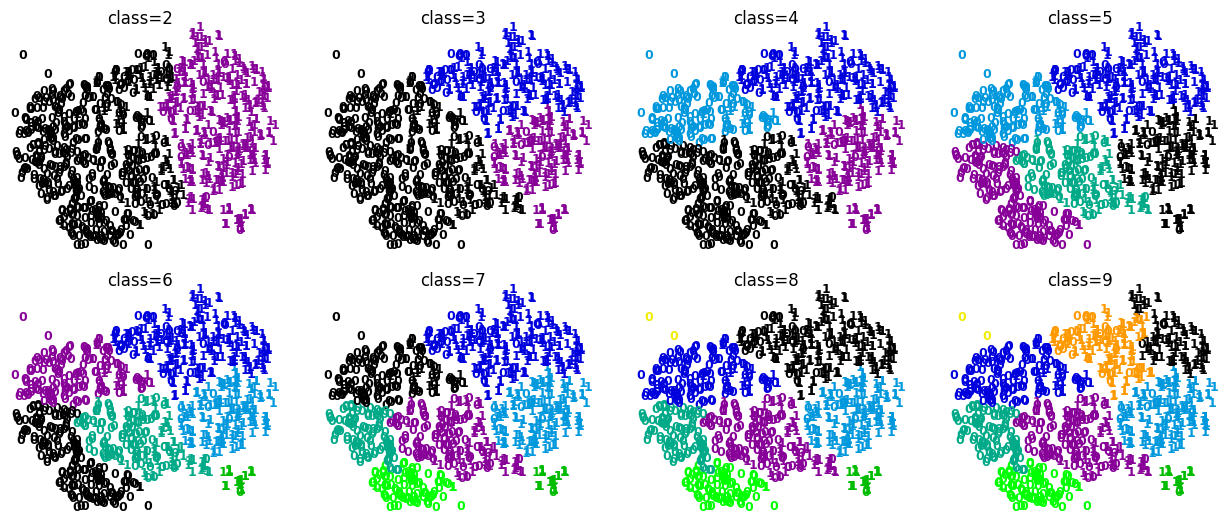

In [8]:
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
reduced_data = model.fit_transform(train_df.loc[:, 0:9])
# pca = PCA(n_components=2, whiten=True)
# reduced_data = pca.fit(train_df.loc[:, 0:9]).transform(train_df.loc[:, 0:9])
plt.figure(1)
plt.clf()
f, axes = plt.subplots(2, 4)
for n_clusters in range(2,10):
    ax = (n_clusters - 2) / 4
    ay = (n_clusters - 2) % 4
    clustering = AgglomerativeClustering(linkage='average', n_clusters=n_clusters)
    clustering.fit(reduced_data)
    
    x_min, x_max = np.min(reduced_data, axis=0), np.max(reduced_data, axis=0)
    reduced_data = (reduced_data - x_min) / (x_max - x_min)
    for i in range(reduced_data.shape[0]):
        axes[ax][ay].text(reduced_data[i, 0], reduced_data[i, 1], str(y_train[i]),
                 color=plt.cm.spectral(clustering.labels_[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    axes[ax][ay].set_xticks([])
    axes[ax][ay].set_yticks([])
    axes[ax][ay].set_title("class={}".format(n_clusters))
    axes[ax][ay].axis('off')

f.subplots_adjust(left=-1, right=1, top=0.6, bottom=-0.6)
plt.show()

# Cluster as Sex Classifier
This chapter measures the similarity of cluster result and sex label when number of group is 2.

In [9]:
from sklearn.metrics import accuracy_score
def bench_classifier(estimator, pca, data, labels):
    if pca > 0 and pca < data.shape[1]:
        pca = PCA(n_components=4, whiten=True)
        data = pca.fit(data).transform(data)
    estimator.fit(data)
    acc = accuracy_score(estimator.labels_, labels)
    return acc if acc >= 0.5 else 1 - acc

names = ['Kmeans, km++ init', 'Kmeans, random init', 'Hier, ward', 'Hier, average', 'Hier, complete']
methods = [
    KMeans(init='k-means++', n_clusters=2, n_init=10),
    KMeans(init='random', n_clusters=2, n_init=10),
    AgglomerativeClustering(linkage='ward', n_clusters=2),
    AgglomerativeClustering(linkage='average', n_clusters=2),
    AgglomerativeClustering(linkage='complete', n_clusters=2),
]
print("Classification accuracy")
res = pd.DataFrame([["{:.4f}".format(bench_classifier(m, i,
                   train_df.loc[:, 0:9], y_train)) for i in [2,4,6,8,-1]] for m in methods],
                   index=names, columns=["pca={}".format(i) for i in ['2','4','6','8','No']]); res

Classification accuracy


,pca=2,pca=4,pca=6,pca=8,pca=No
"Kmeans, km++ init",0.5440,0.5335,0.5335,0.5419,0.8952
"Kmeans, random init",0.5356,0.5356,0.5419,0.5356,0.8952
"Hier, ward",0.5566,0.5566,0.5566,0.5566,0.9036
"Hier, average",0.5073,0.5073,0.5073,0.5073,0.5073
"Hier, complete",0.5199,0.5199,0.5199,0.5199,0.5021


In [10]:
def prop_classifier(estimator, pca, data, labels):
    if pca > 0 and pca < data.shape[1]:
        pca = PCA(n_components=4, whiten=True)
        data = pca.fit(data).transform(data)
    estimator.fit(data)
    prop = np.bincount(estimator.labels_)/float(data.shape[0])
    return prop[0] if prop[0] >= 0.5 else prop[1]
print("Proportion of major group")
res = pd.DataFrame([["{:.4f}".format(prop_classifier(m, i,
                   train_df.loc[:, 0:9], y_train)) for i in [2,4,6,8,-1]] for m in methods],
                   index=names, columns=["pca={}".format(i) for i in ['2','4','6','8','No']]); res

Proportion of major group


,pca=2,pca=4,pca=6,pca=8,pca=No
"Kmeans, km++ init",0.5136,0.5157,0.5136,0.5115,0.5294
"Kmeans, random init",0.5115,0.5115,0.5136,0.5115,0.5294
"Hier, ward",0.6017,0.6017,0.6017,0.6017,0.5000
"Hier, average",0.9990,0.9990,0.9990,0.9990,0.9990
"Hier, complete",0.9549,0.9549,0.9549,0.9549,0.9937
